In [9]:
import os
import h5py
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

In [27]:
mat_dir = 'SpectrumData/mat_files' 
tif_dir = 'SpectrumData/tif_files'
os.makedirs(tif_dir, exist_ok=True)

In [4]:
with h5py.File('SpectrumData/mat_files/object_2024-06-17_09-28-46.mat', 'r') as f:
    print("Keys: ", list(f.keys())) 
    for key in f.keys():
        print(f"{key}: {f[key]}")

Keys:  ['I']
I: <HDF5 dataset "I": shape (224, 1024, 2467), type "<f8">


In [52]:
def convert_mat_to_tif(mat_file, tif_file):
    with h5py.File(mat_file, 'r') as f:
        hyperspectral_data = np.array(f['I'])
        hyperspectral_data = np.transpose(hyperspectral_data, (2, 1, 0))

        tiff.imwrite(tif_file, hyperspectral_data, photometric='minisblack')


In [53]:
for mat_file in os.listdir(mat_dir):
    if mat_file.endswith('.mat'):
        mat_path = os.path.join(mat_dir, mat_file)
        tif_path = os.path.join(tif_dir, os.path.splitext(mat_file)[0] + '.tif')
        convert_mat_to_tif(mat_path, tif_path)
        print(f"Converted {mat_file} to {os.path.splitext(mat_file)[0]}.tif")

print("Conversion complete.")

Converted object_2024-06-17_10-19-19.mat to object_2024-06-17_10-19-19.tif
Converted object_2024-06-17_09-28-46.mat to object_2024-06-17_09-28-46.tif
Converted object_2024-06-17_09-47-21.mat to object_2024-06-17_09-47-21.tif
Converted object_2024-06-17_10-05-18.mat to object_2024-06-17_10-05-18.tif
Conversion complete.


In [24]:
def tif_image(tif_file):
    image_data = tiff.imread(tif_path)
    print(f"Image shape: {image_data.shape}")

    rgb_image = np.stack([
        image_data[:, :, 0],  # Red channel
        image_data[:, :, 1],  # Green channel
        image_data[:, :, 2]   # Blue channel
     ], axis=-1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title('RGB Composite')
    plt.axis('off')
    plt.show()
    return 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (224, 1024, 2485)


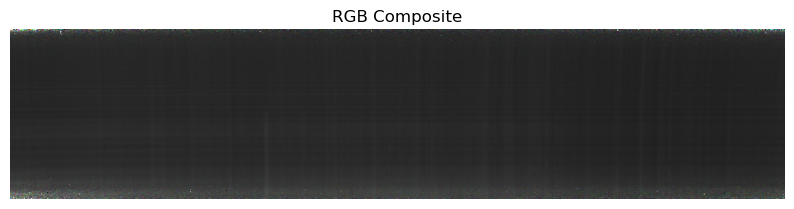

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (224, 1024, 2485)


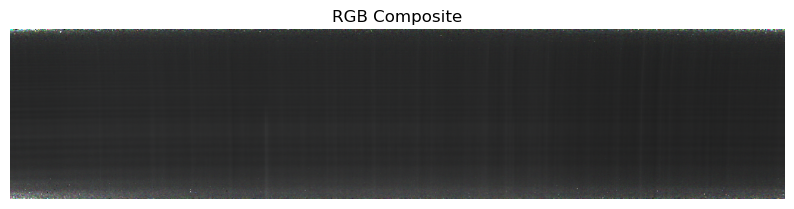

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (224, 1024, 2474)


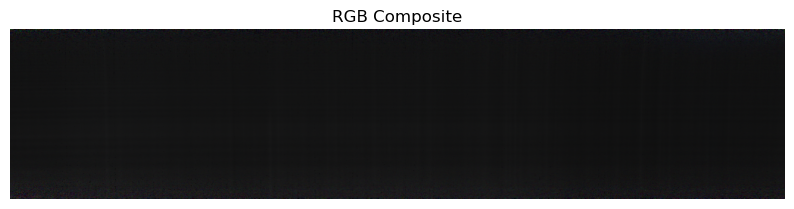

Image shape: (224, 1024, 2467)


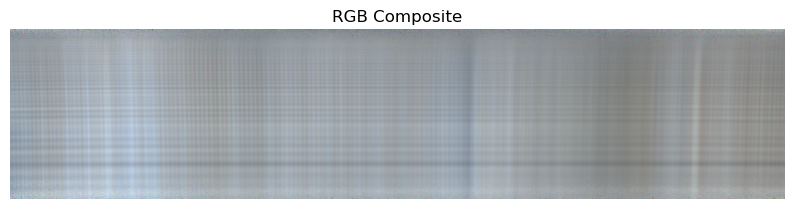

In [54]:
for tif_file in os.listdir(tif_dir):
    if tif_file.endswith('.tif'):
        tif_path = os.path.join(tif_dir, tif_file)
        tif_image(tif_path)



# Data Import

In [3]:
import pandas as pd
from PIL import Image
from matplotlib.colors import ListedColormap

In [4]:
data_all_path = "csv_files/hyperspectral_bacterial_fungal_biofilms_6_species.xls"
data_train_path = "csv_files/hyperspectral_bacterial_fungal_biofilms_6_species_train.xls"
data_test_path = "csv_files/hyperspectral_bacterial_fungal_biofilms_6_species_test.xls"

In [5]:
groups_names_pd = pd.read_excel(data_all_path, index_col=0, sheet_name="Group")

In [6]:
data_all_pd = pd.read_excel(data_all_path, index_col=0)
data_train_pd = pd.read_excel(data_train_path, index_col=0)
data_test_pd = pd.read_excel(data_test_path, index_col=0)

In [7]:
mask = np.array(Image.open(os.path.join('object_2024-06-17_09-28-46.mask.png')))
mask_unique = np.unique(mask)
mask_unique = mask_unique[1:]
mask_unique = pd.DataFrame(mask_unique, columns = ['Record_ID'])

In [8]:
df_merge_test_and_group = pd.merge(mask_unique, data_all_pd, on='Record_ID', how='left')

# Mask visualisation

In [9]:
experiment_to_bacteria = pd.Series(df_merge_test_and_group.Group.values, index=df_merge_test_and_group.Record_ID).to_dict()

In [10]:
# Функция для замены номеров экспериментов на названия бактерий
def replace_experiment_with_bacteria(array, mapping):
    return [[mapping.get(item, item) for item in sublist] for sublist in array]

In [11]:
bacteria_mask = replace_experiment_with_bacteria(mask, experiment_to_bacteria)

In [12]:
colors = np.random.rand(len(np.unique(bacteria_mask)), 3)
colors[0] = np.array([1, 1, 1])
cmap = ListedColormap(colors)

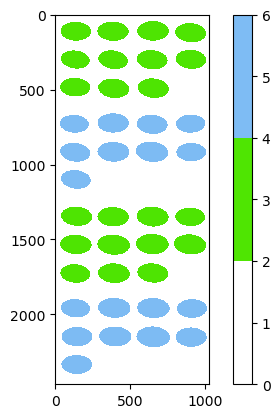

In [13]:
plt.imshow(bacteria_mask, cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.show()

# .tiff visualisation

In [1]:
import tifffile as tiff
from PIL import Image, ImageSequence
from sklearn.decomposition import PCA
from pathlib import Path

In [2]:
def visualize_pca(data):
    # Reshape data
    height, width, bands = data.shape
    data_reshaped = data.reshape((height * width, bands))
    
    # Применение PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data_reshaped)
    
    # Reshape back to image dimensions
    pca_image = pca_result.reshape((height, width, 3))
    
    # Нормализация для отображения
    pca_image = (pca_image - pca_image.min()) / (pca_image.max() - pca_image.min())
    
    plt.figure(figsize=(6, 6))
    plt.imshow(pca_image)
    plt.title('PCA Visualization')
    plt.show()

In [3]:
def create_rgb_composite(data, r_channel, g_channel, b_channel):
    rgb = np.dstack((data[:, :, r_channel],
                     data[:, :, g_channel],
                     data[:, :, b_channel]))
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Нормализация
    
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.title('RGB Composite')
    plt.show()

In [12]:
def visualize_channel(data, channel):
    plt.figure(figsize=(6, 6))
    plt.imshow(data[:, :, channel], cmap='viridis')
    plt.colorbar()
    plt.title(f'Channel {channel}')
    plt.show()

In [4]:
def split_image_to_wells(image_path, output_dir, rows=12, cols=4):
    image = tiff.imread(image_path)
    height, width = image.shape[:2]

    # Размеры каждой лунки
    cell_width = width // cols
    cell_height = height // rows

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    well_images = []
    for row in range(rows):
        for col in range(cols):
            left = col * cell_width
            upper = row * cell_height
            right = (col + 1) * cell_width
            lower = (row + 1) * cell_height
            well_image = image[upper:lower, left:right]
            well_image_path = output_dir / f'well_{row+1}_{col+1}.tif'
            tiff.imwrite(well_image_path, well_image)
            well_images.append(well_image_path)
    
    return well_images


In [6]:
image_path = '/Users/a1/Documents/letiLab/spectrum/tif/object_2024-06-17_09-28-46.tif'
output_dir = 'wells_output'

well_images = split_image_to_wells(image_path, output_dir)

print(f'Saved {len(well_images)} well images.')

Saved 48 well images.


In [11]:
tiff_data = tiff.imread('wells_output/well_1_3.tif')

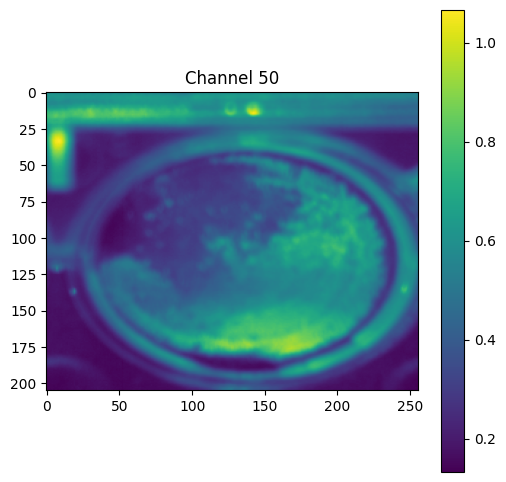

In [14]:
visualize_channel(tiff_data, 50)

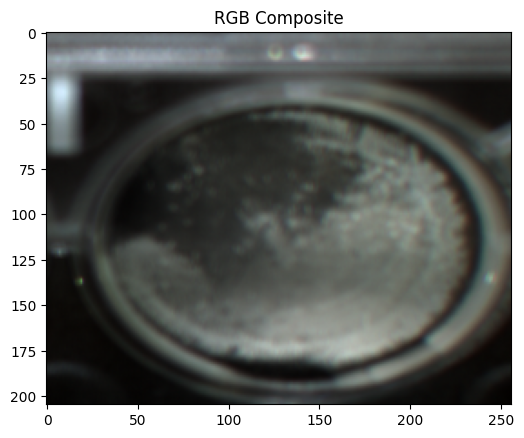

In [15]:
create_rgb_composite(tiff_data, 50, 100, 150)

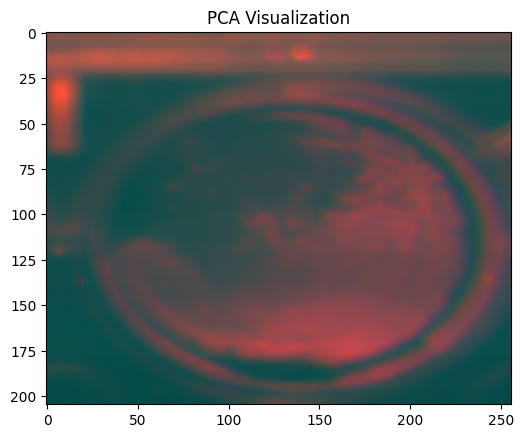

In [16]:
visualize_pca(tiff_data)